# COVID 19 predications for 163 countries

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

import calendar

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree


In [2]:
#loading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

# Data exploration and interpretation

In [3]:
#Adding a new column i.e. Month which pulls the month data from 'Date'
train['Month'] = pd.DatetimeIndex(train['Date']).month
train['Month'] = train['Month'].apply(lambda x: calendar.month_abbr[x])

# Reset Train Data with columns in desired order (i.e. Moving Month column after date)
train = train[['Id', 'Province/State','Country/Region','Lat','Long','Date', 'Month', 'ConfirmedCases', 'Fatalities']]

In [4]:
train.head(10)

,Id,Province/State,Country/Region,Lat,Long,Date,Month,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,Jan,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,Jan,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,Jan,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,Jan,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,Jan,0.0,0.0
5,6,NaN,Afghanistan,33.0,65.0,2020-01-27,Jan,0.0,0.0
6,7,NaN,Afghanistan,33.0,65.0,2020-01-28,Jan,0.0,0.0
7,8,NaN,Afghanistan,33.0,65.0,2020-01-29,Jan,0.0,0.0
8,9,NaN,Afghanistan,33.0,65.0,2020-01-30,Jan,0.0,0.0
9,10,NaN,Afghanistan,33.0,65.0,2020-01-31,Jan,0.0,0.0


In [5]:
# Getting the stats for the 'train' data
train.describe()

,Id,Lat,Long,ConfirmedCases,Fatalities
count,17892.000000,17892.000000,17892.000000,17892.000000,17892.000000
mean,13191.500000,26.287693,4.766191,325.207523,11.974737
std,7624.675152,22.935092,79.923261,3538.599684,174.346267
min,1.000000,-41.454500,-157.498300,0.000000,0.000000
25%,6596.250000,13.145425,-71.516375,0.000000,0.000000
50%,13191.500000,32.985550,9.775000,0.000000,0.000000
75%,19786.750000,42.501575,64.688975,10.000000,0.000000
max,26382.000000,71.706900,174.886000,69176.000000,6820.000000


In [6]:
# Checking the type for all columns in the data
for i in train.columns:
     if train[i].dtype.name == 'object':
            print(i, ": OBJECT")
     else:
        print(i, " : Number column")
        
train.Date.dtype  

Id  : Number column
Province/State : OBJECT
Country/Region : OBJECT
Lat  : Number column
Long  : Number column
Date : OBJECT
Month : OBJECT
ConfirmedCases  : Number column
Fatalities  : Number column


dtype('O')

In [7]:
# Checking the data dates (i.e. data is available from Mid Jan to mid March)
print(train['Date'].min(), ' - ', train['Date'].max())

2020-01-22  -  2020-03-24


In [8]:
# Getting Unique list of countries
Unique_names = train['Country/Region'].unique()
print(Unique_names)
print(len(Unique_names))

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria' 'Azerbaijan'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Benin' 'Bhutan'
 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chile' 'China' 'Colombia' 'Congo (Brazzaville)' 'Congo (Kinshasa)'
 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cruise Ship' 'Cuba' 'Cyprus'
 'Czechia' 'Denmark' 'Djibouti' 'Dominican Republic' 'Ecuador' 'Egypt'
 'Equatorial Guinea' 'Estonia' 'Eswatini' 'Ethiopia' 'Finland' 'France'
 'French Guiana' 'Gabon' 'Gambia, The' 'Georgia' 'Germany' 'Ghana'
 'Greece' 'Greenland' 'Guadeloupe' 'Guam' 'Guatemala' 'Guernsey' 'Guinea'
 'Guyana' 'Holy See' 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jersey'
 'Jordan' 'Kazakhstan' 'Kenya' 'Korea, South' 'Kosovo' 'Kuwait'
 'Kyrgyzstan' 'Latvia' 'Leba

In [9]:
# Checking Daily Worldwide Fatalities for particular dates
New_train_Fatalities = train.groupby('Date')['Date', 'Fatalities'].max().reset_index
New_train_Fatalities
#We have noticed that Fatalities had increaed gradually in March

<bound method DataFrame.reset_index of                   Date  Fatalities
Date                              
2020-01-22  2020-01-22        17.0
2020-01-23  2020-01-23        17.0
2020-01-24  2020-01-24        24.0
2020-01-25  2020-01-25        40.0
2020-01-26  2020-01-26        52.0
...                ...         ...
2020-03-20  2020-03-20      4032.0
2020-03-21  2020-03-21      4825.0
2020-03-22  2020-03-22      5476.0
2020-03-23  2020-03-23      6077.0
2020-03-24  2020-03-24      6820.0

[63 rows x 2 columns]>

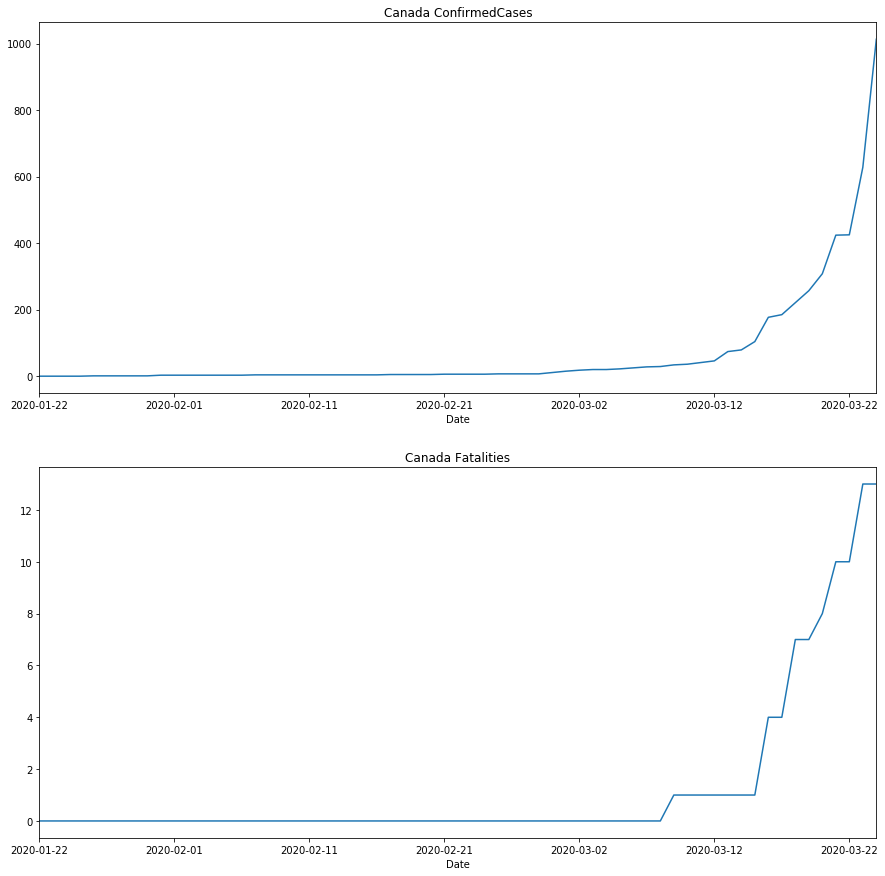

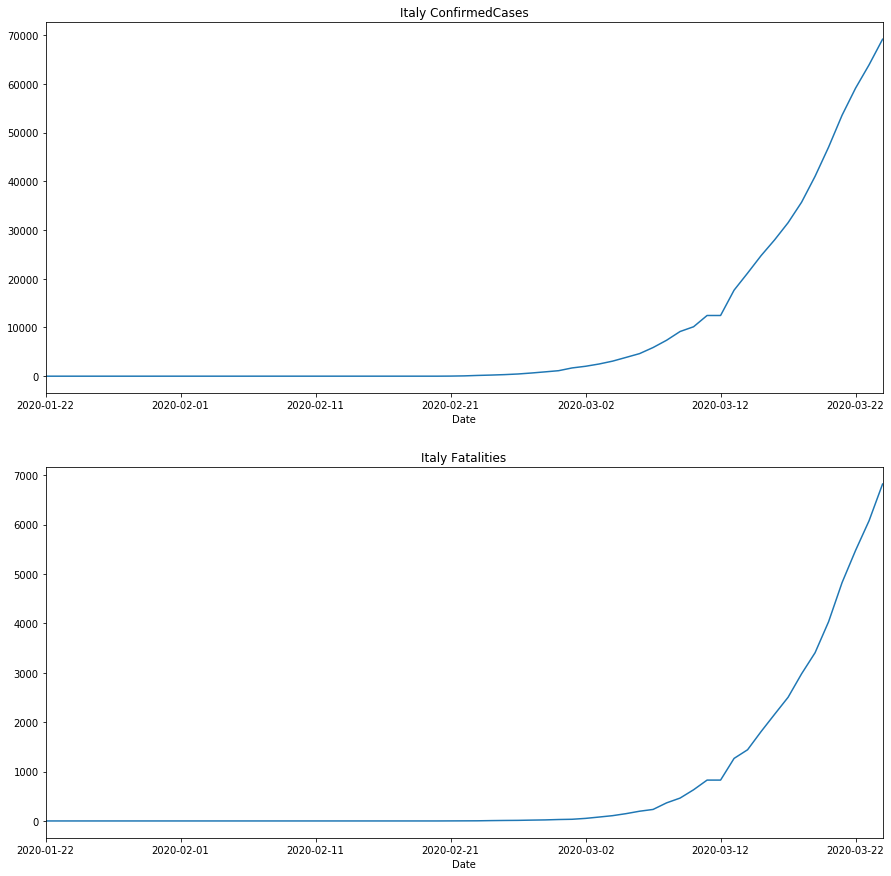

In [10]:
#Interpreting the data in the form of Graphs

#Checking the cases based for Specific country for all dates
def country_stats(country, train):
    country_filter = (train['Country/Region'] == country)
    train_cases = train.loc[country_filter].groupby(['Date'])['ConfirmedCases'].max()
    train_fatal = train.loc[country_filter].groupby(['Date'])['Fatalities'].max()
    fig, axes = plt.subplots(nrows = 2, ncols= 1, figsize=(15,15))
    train_cases.plot(ax = axes[0], title = country + ' ConfirmedCases')
    train_fatal.plot(ax = axes[1], title = country + ' Fatalities')
    
country_stats('Canada', train)
country_stats('Italy', train)
# Checked two country, what we noticed that Fatalities and confirmed cases has started increasing after March 12th for both the countries
# Earlier we do have cases but it was controllable
# Based on these graph we can say that 1st Phase has started in March 

In [11]:
# We will show how much ConfirmedCases and Fatalities has been caused Countries wise

Cases_Country = train.groupby(['Country/Region'], as_index=False)['ConfirmedCases'].max()

# Sorting by number of cases
Cases_Country.sort_values('ConfirmedCases', ascending=False, inplace = True)
Cases_Country

,Country/Region,ConfirmedCases
75,Italy,69176.0
29,China,67801.0
139,Spain,39885.0
55,Germany,32986.0
154,US,25681.0
...,...,...
148,The Bahamas,0.0
62,Guernsey,0.0
60,Guam,0.0
59,Guadeloupe,0.0


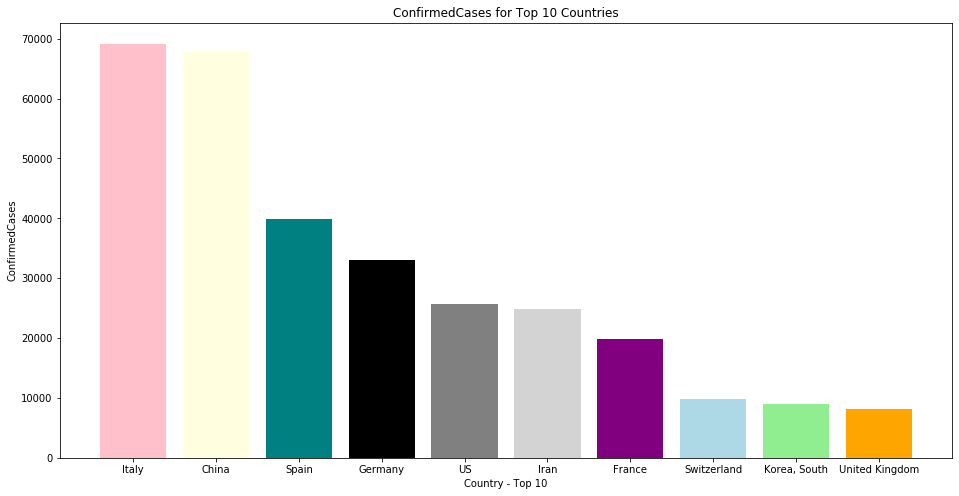

In [12]:
# Showing the above data on the graph showing for top 10 countries
plt.figure(figsize=(16, 8))
plt.bar(Cases_Country['Country/Region'][:10], Cases_Country['ConfirmedCases'][:10], color = ['pink', 'lightyellow','teal','black','grey','lightgrey','purple','Lightblue','Lightgreen','orange'])
plt.xlabel("Country - Top 10")
plt.ylabel("ConfirmedCases")
plt.title("ConfirmedCases for Top 10 Countries")
plt.show()

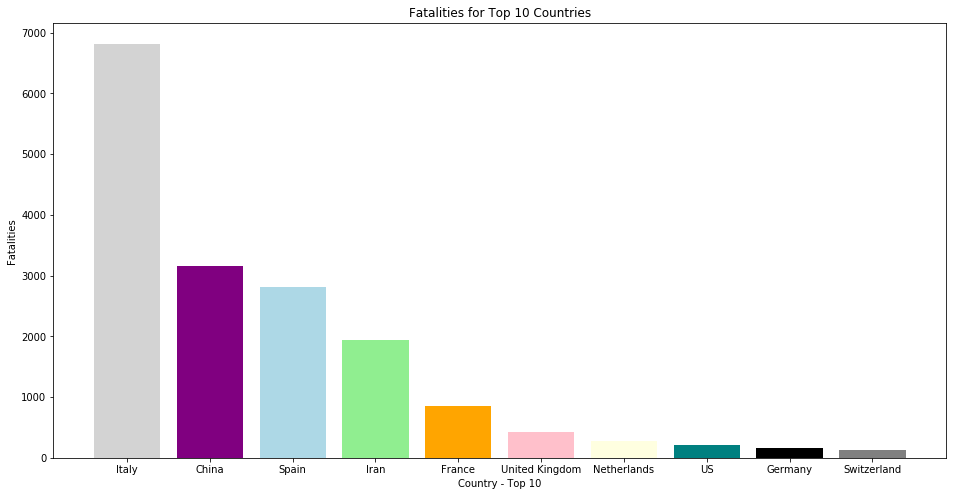

In [13]:
# Showing the Graph for Fatalities for Top10 countries

Fatalities_Country = train.groupby(['Country/Region'], as_index=False)['Fatalities'].max()

# Sorting by number of Fatalities
Fatalities_Country.sort_values('Fatalities', ascending=False, inplace = True)

plt.figure(figsize=(16, 8))
plt.bar(Fatalities_Country['Country/Region'][:10], Fatalities_Country['Fatalities'][:10], color = ['lightgrey','purple','Lightblue','Lightgreen','orange','pink', 'lightyellow','teal','black','grey'])
plt.xlabel("Country - Top 10")
plt.ylabel("Fatalities")
plt.title("Fatalities for Top 10 Countries")
plt.show()
# Observing ConfirmedCases and Fatalities Graphs, we have noticed that though the Aggregate ConfirmedCases are nea rly the same for Itlay and China,but the Fatalities were more in Italy compared to China.
# Same is the case of Iran and Germany.
# We can see UK is the last in the TOP10 list in terms of ConfirmedCases, however it's ranked on sixth position in terms of overall Fatalities

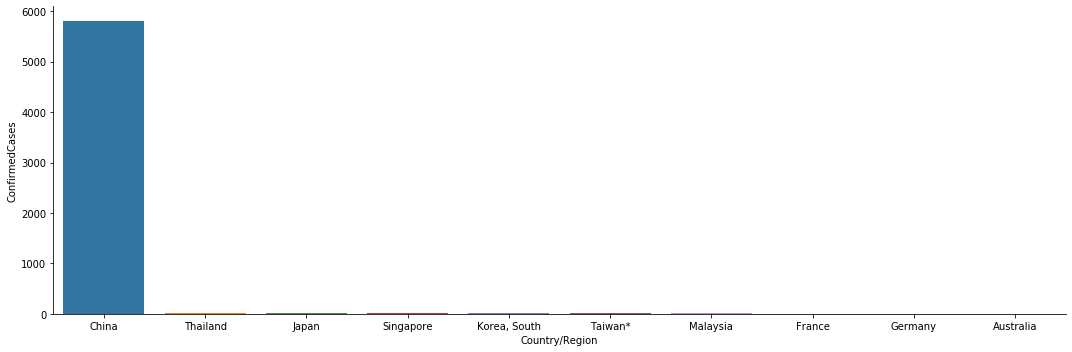

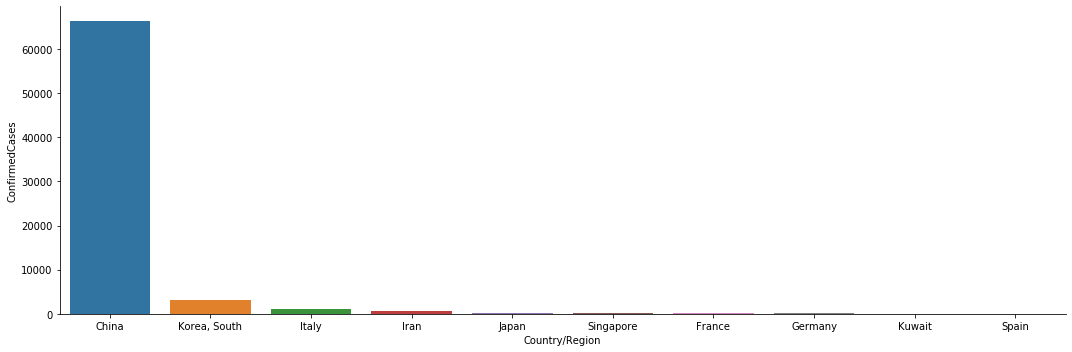

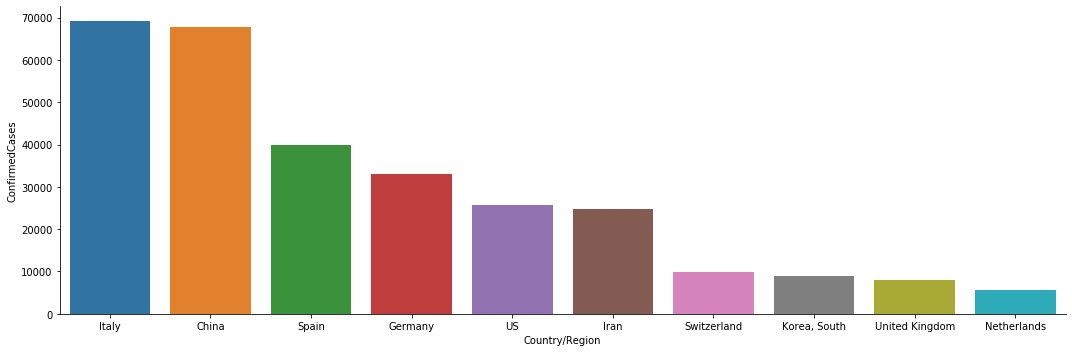

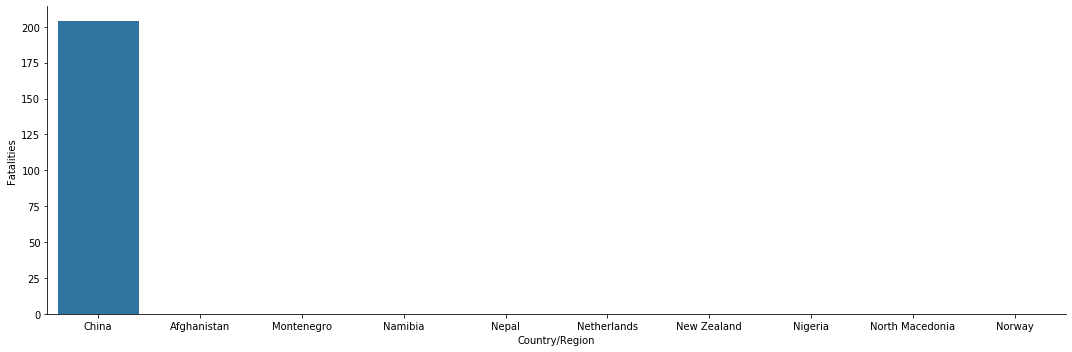

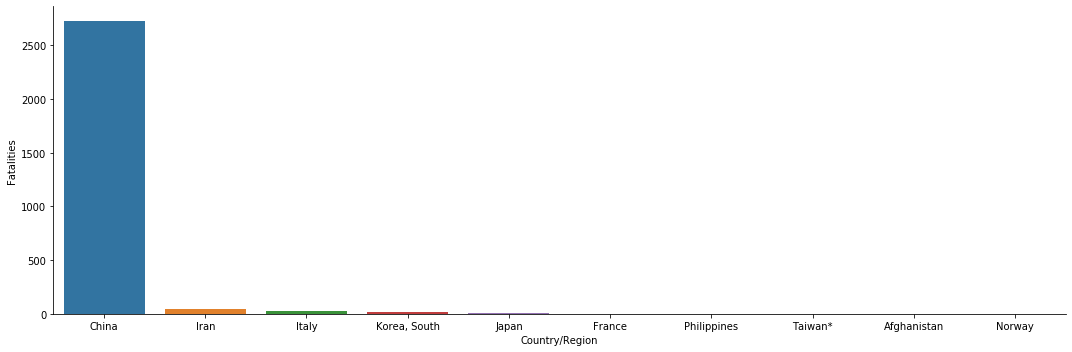

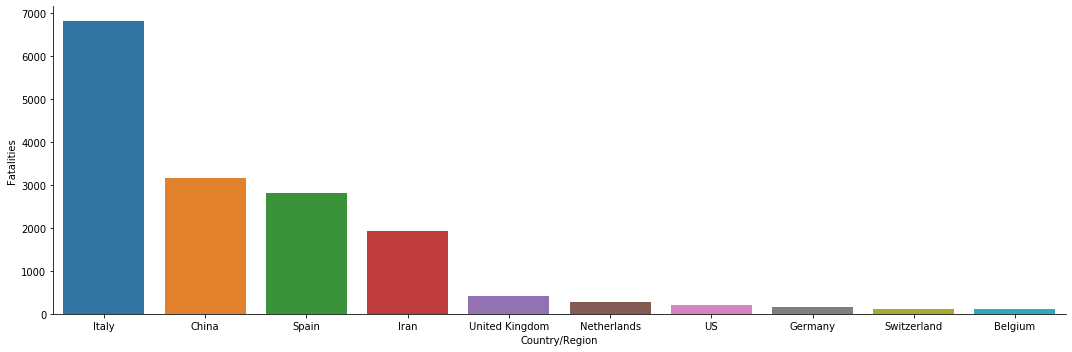

In [14]:
def cases_vs_date (Date, train):
    train = train.groupby(['Country/Region', 'Date'], as_index = False)['ConfirmedCases'].max()
    date_filter = (train['Date'] == Date)
    train = train.loc[date_filter]
    train.sort_values('ConfirmedCases', ascending = False, inplace = True)
    sns.catplot(x = 'Country/Region', y = 'ConfirmedCases' , data = train.head(10), height=5,aspect=3, kind = 'bar')
    
def fatal_vs_date (Date, train):
    train = train.groupby(['Country/Region', 'Date'], as_index = False)['Fatalities'].max()
    date_filter = (train['Date'] == Date)
    train = train.loc[date_filter]
    train.sort_values('Fatalities', ascending = False, inplace = True)
    sns.catplot(x = 'Country/Region', y = 'Fatalities' , data = train.head(10), height=5,aspect=3, kind = 'bar')
    
    
cases_vs_date('2020-01-31', train)
cases_vs_date('2020-02-29', train)
cases_vs_date('2020-03-24', train)

fatal_vs_date('2020-01-31', train)
fatal_vs_date('2020-02-29', train)
fatal_vs_date('2020-03-24', train)

# As we can see below based on the month end data for each month we have noticed that in January there were only cases (ConfirmedCases and Fatalities) were China. 
# For February we have noticed that this started spreading in other countries like South Korea, Itlay and Iran

# For March we can see the Confirmed Cases for particular country like Iran was less but the Fatalities are more in comparision to it

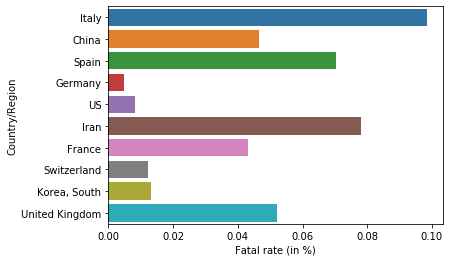

In [15]:
# Seeing the data for the TOP 10 countries with the confirmed cases:
train_cases=train.groupby('Country/Region')['ConfirmedCases','Fatalities'].max().reset_index().sort_values('ConfirmedCases',ascending=False)    
train_cases['Fatal rate (in %)'] = train_cases['Fatalities']/train_cases['ConfirmedCases']
Top10_traindata=train_cases[:10]
sns.barplot(y='Country/Region',x='Fatal rate (in %)',data=Top10_traindata)

## Here we can see that Fatalities per ConfirmedCases are more in Italy followed by Iran and then Spain
# Similar to what we have seen above

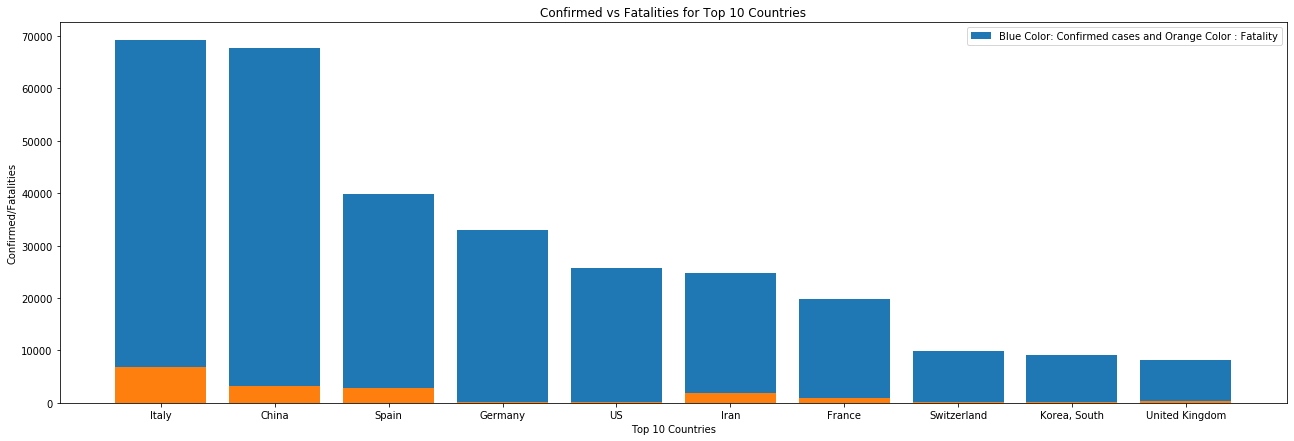

In [16]:
train_cases=train.groupby('Country/Region')['ConfirmedCases','Fatalities'].max().reset_index().sort_values('ConfirmedCases',ascending=False)    

plt.figure(figsize=(22,7))
plt.bar(train_cases['Country/Region'][:10],train_cases['ConfirmedCases'][:10])
plt.bar(train_cases['Country/Region'][:10],train_cases['Fatalities'][:10])
plt.legend(['Blue Color: Confirmed cases and Orange Color : Fatality'])
plt.xlabel("Top 10 Countries")
plt.ylabel("Confirmed/Fatalities")
plt.title("Confirmed vs Fatalities for Top 10 Countries")
plt.show()

# We can see below the Top 10 countries with more of the ConfirmedCases report in the period of Mid Jan to Mid March

Text(0.5, 0, 'Date')

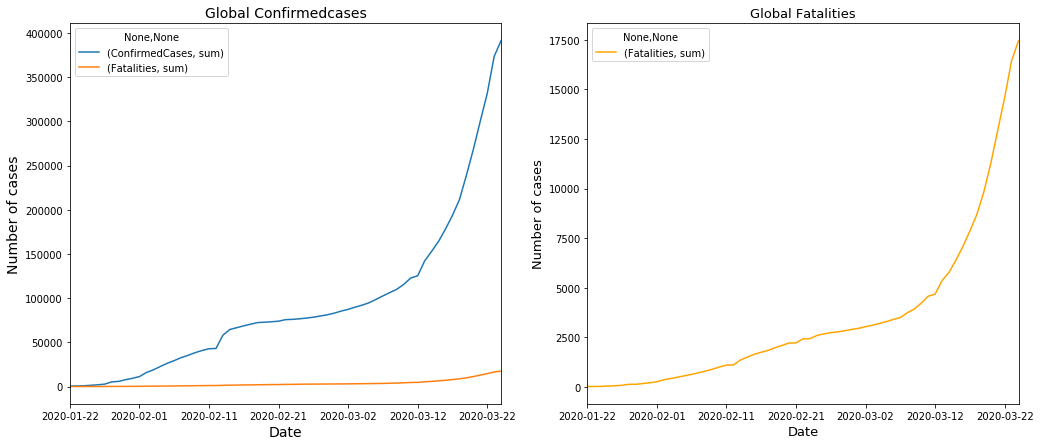

In [17]:
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global Confirmedcases", size=14)
ax1.set_ylabel("Number of cases", size=14)
ax1.set_xlabel("Date", size=14)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global Fatalities", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

# Below we can see that ConfirmedCases started increasing after Feb 11th and then getting steep after March 12
# For Fatalities we can see almost the same criteria

# Data Preprocessing

In [18]:
#filling NaN with blanks
Cleaned_train = train['Province/State'].fillna(" ", inplace = True)

#Formatting Date for future prediction
train["Date"] = train["Date"].apply(lambda x: x.replace("-",""))
train["Date"] = train["Date"].astype(int)

#droping ID column
train = train.drop('Id', axis = 1)

train.head()

,Province/State,Country/Region,Lat,Long,Date,Month,ConfirmedCases,Fatalities
0,,Afghanistan,33.0,65.0,20200122,Jan,0.0,0.0
1,,Afghanistan,33.0,65.0,20200123,Jan,0.0,0.0
2,,Afghanistan,33.0,65.0,20200124,Jan,0.0,0.0
3,,Afghanistan,33.0,65.0,20200125,Jan,0.0,0.0
4,,Afghanistan,33.0,65.0,20200126,Jan,0.0,0.0


In [19]:
#Cleaning the test data
test['Date'] = pd.to_numeric(test.Date.str.replace('-',''))
test["Date"]  = test["Date"].astype(int)
test.head()

,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,20200312
1,2,NaN,Afghanistan,33.0,65.0,20200313
2,3,NaN,Afghanistan,33.0,65.0,20200314
3,4,NaN,Afghanistan,33.0,65.0,20200315
4,5,NaN,Afghanistan,33.0,65.0,20200316


# Training the prediction Algorithm

In [20]:
#Assiging the columns:
X = train[['Lat', 'Long', 'Date']]
y_confirm = train[['ConfirmedCases']]
y_fatal = train[['Fatalities']]
X_test = test[['Lat', 'Long', 'Date']]

In [21]:
# Applying RandonForestRegression on Confirmedcases
classifier = RandomForestRegressor(random_state = 42)
classifier.fit(X,y_confirm)


C:\Users\nehaa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(random_state=42)

In [22]:
Prediction = classifier.predict(X_test)
Prediction = pd.DataFrame(Prediction).round()
Prediction.columns = ["ConfirmedCases_prediction"]
Prediction.head()

,ConfirmedCases_prediction
0,8.0
1,8.0
2,12.0
3,21.0
4,21.0


In [23]:
# Applying RandonForestRegression on Fatalities
classifier = RandomForestRegressor(random_state = 42)
classifier.fit(X,y_fatal)

#Predicting the Fatalities
Prediction2 = classifier.predict(X_test)
Prediction2 = pd.DataFrame(Prediction2).round()
Prediction2.columns = ["Fatalities_Prediction"]
Prediction2.head()

C:\Users\nehaa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


,Fatalities_Prediction
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [24]:
 # Checking with DecisionTree Regressor

Classifier_Tree = DecisionTreeRegressor(random_state=42)
Classifier_Tree.fit(X,y_confirm)

DecisionTreeRegressor(random_state=42)

In [25]:
# Predicting the Confirmed Cases
Predictiontree = Classifier_Tree.predict(X_test)
Predictiontree = pd.DataFrame(Predictiontree).round()
Predictiontree.columns = ["ConfirmedCases_predictiontree"]
Predictiontree.head()

,ConfirmedCases_predictiontree
0,7.0
1,7.0
2,11.0
3,20.0
4,20.0


In [26]:
## Predicting the Fatalities Cases

Classifier_Tree=DecisionTreeRegressor(random_state=42)
Classifier_Tree.fit(X,y_fatal)

Predictiontree2 = Classifier_Tree.predict(X_test)
Predictiontree2 = pd.DataFrame(Predictiontree2).round()
Predictiontree2.columns = ["Fatality_predictiontree"]
Predictiontree2.head()



,Fatality_predictiontree
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


# Adding the Predictions to the test data and analysing the results

In [27]:
# Converting back the 'Date' format in test data
from datetime import datetime
test['Date'] = pd.to_datetime(test['Date'].astype(str), format ='%Y-%m-%d')
test.head()

,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16


In [28]:
test = pd.concat([test, Prediction, Prediction2], axis = 1)
test.head(10)

,ForecastId,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases_prediction,Fatalities_Prediction
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12,8.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13,8.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14,12.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15,21.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16,21.0,0.0
5,6,NaN,Afghanistan,33.0,65.0,2020-03-17,21.0,0.0
6,7,NaN,Afghanistan,33.0,65.0,2020-03-18,25.0,0.0
7,8,NaN,Afghanistan,33.0,65.0,2020-03-19,26.0,0.0
8,9,NaN,Afghanistan,33.0,65.0,2020-03-20,26.0,0.0
9,10,NaN,Afghanistan,33.0,65.0,2020-03-21,26.0,0.0


In [29]:
#Adding a new column i.e. Month which pulls the month data from 'Date'
test['Month'] = pd.DatetimeIndex(test['Date']).month
test['Month'] = test['Month'].apply(lambda x: calendar.month_abbr[x])

# Reset test_new Data with columns in desired order (i.e. Moving Month column after date)
test = test[['ForecastId', 'Province/State','Country/Region','Lat','Long','Date', 'Month', 'ConfirmedCases_prediction', 'Fatalities_Prediction']]


test.head()

,ForecastId,Province/State,Country/Region,Lat,Long,Date,Month,ConfirmedCases_prediction,Fatalities_Prediction
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12,Mar,8.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13,Mar,8.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14,Mar,12.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15,Mar,21.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16,Mar,21.0,0.0


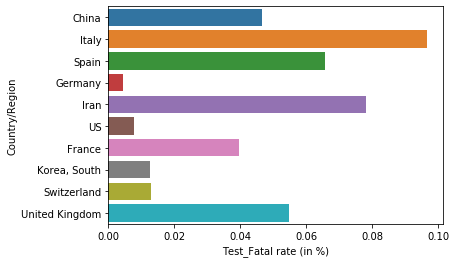

In [30]:
# Fatal Rate:
test_cases=test.groupby('Country/Region')['ConfirmedCases_prediction','Fatalities_Prediction'].max().reset_index().sort_values('ConfirmedCases_prediction',ascending=False)    

test_cases['Test_Fatal rate (in %)'] = test_cases['Fatalities_Prediction']/test_cases['ConfirmedCases_prediction']
Top10_testdata=test_cases[:10]
sns.barplot(y='Country/Region',x='Test_Fatal rate (in %)',data=Top10_testdata)

# We have noticed that even in Mid March and April the Fatal rate per Confirmed Cases (Prediction) was high in Italy followed by Iran and then Spain but now the % has increaed compared to the Train data

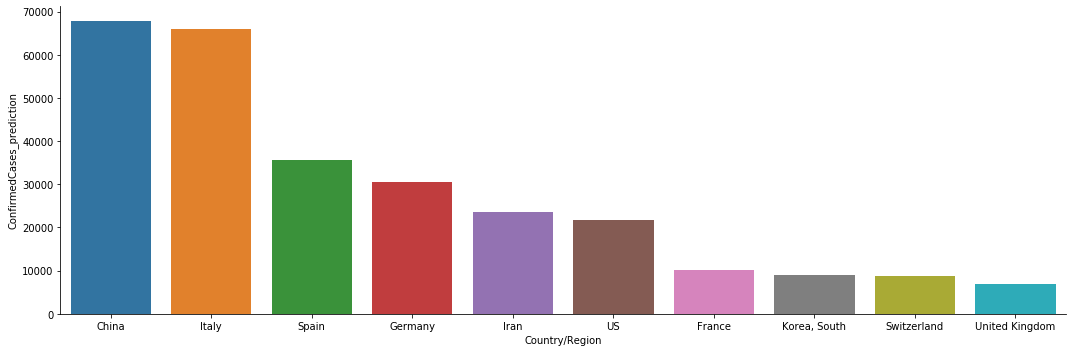

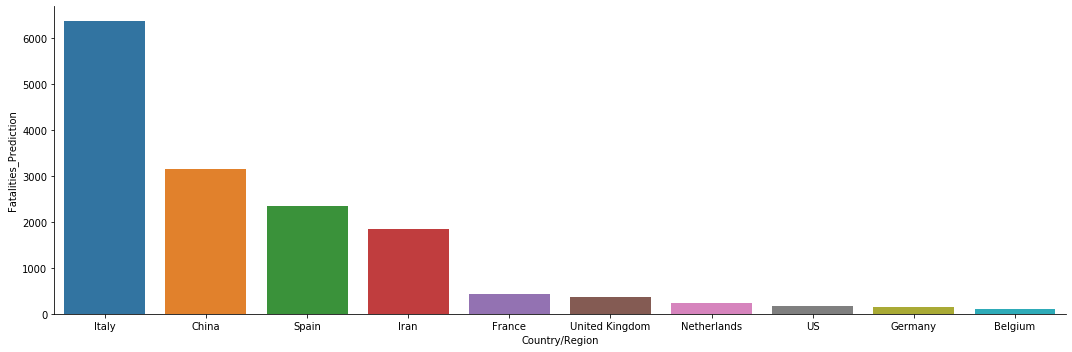

In [31]:
# ConfirmedCases and Fatalities for a particular day in top 10 countries
def cases_vs_date (Date, test):
    test = test.groupby(['Country/Region', 'Date'], as_index = False)['ConfirmedCases_prediction'].max()
    date_filter = (test['Date'] == Date)
    test = test.loc[date_filter]
    test.sort_values('ConfirmedCases_prediction', ascending = False, inplace = True)
    sns.catplot(x = 'Country/Region', y = 'ConfirmedCases_prediction' , data = test.head(10), height=5,aspect=3, kind = 'bar')

def fatal_vs_date (Date, test):
    test = test.groupby(['Country/Region', 'Date'], as_index = False)['Fatalities_Prediction'].max()
    date_filter = (test['Date'] == Date)
    test = test.loc[date_filter]
    test.sort_values('Fatalities_Prediction', ascending = False, inplace = True)
    sns.catplot(x = 'Country/Region', y = 'Fatalities_Prediction' , data = test.head(10), height=5,aspect=3, kind = 'bar')
    
    
cases_vs_date('2020-04-23', test) 
    
fatal_vs_date('2020-04-23', test)

# What we have noticed here is that the Cases are more in China than in Italy, but the Fatalities are more in Italy confirmed to other countries even from the period of mid March to mid Apri

# Global Interpretability through SHAP Tree Explainer

In [32]:
!pip install shap
import shap

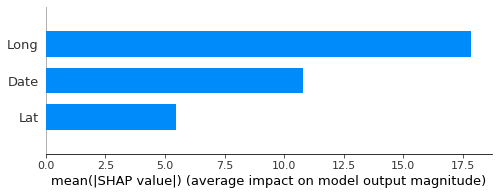

In [33]:
shap_values = shap.TreeExplainer(classifier).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

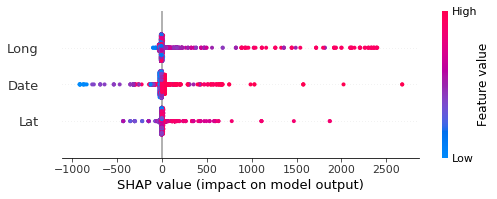

In [36]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)